In [4]:
import numpy as np
import pandas as pd
import itertools
import random
import time
import matplotlib.pyplot as plt


from sklearn.datasets import load_boston
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from modAL.models import ActiveLearner

from sklearn import datasets
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

### Preparing data

In [5]:
# loading the boston dataset
data_generated=1000

x= np.array([random.random() for i in range(data_generated)])

x_carré_b=x.reshape([x.size,1])
y_carré_b=(x**2 + np.array([np.random.normal(loc=0,scale=0.05) for i in range(data_generated)])).reshape((data_generated,1))

boston = load_boston()
X_boston, y_boston = boston['data'], boston['target'].reshape((len(boston['target']),1))

columns_names=["Frequency","Angle of attack","Chord length","Free-stream velocity","Suction side displacement thickness","sound pressure level"]
airfoil=pd.read_csv('C:/Users/matth/jupyter codes/Recherche/datasets/airfoil_self_noise.dat',sep='\t',names=columns_names)
y_airfoil=airfoil["sound pressure level"].values.reshape((len(airfoil["sound pressure level"]),1))
X_airfoil=airfoil.drop("sound pressure level",axis=1).values

energy=pd.read_csv('C:/Users/matth/jupyter codes/Recherche/datasets/energy efficiency.csv')
y_energy=energy["Y2"].values.reshape((len(energy["Y2"]),1))
X_energy=energy.drop(["Y2","Y1"],axis=1)



maintenance=pd.read_csv('C:/Users/matth/jupyter codes/Recherche/datasets/conditions_based_maintenance/data.txt',sep="   ", header=None)
y_maintenance=maintenance[17].values.reshape((len(maintenance[17]),1))
X_maintenance=maintenance.drop([16,17],axis=1)



"""forest=pd.read_csv('C:/Users/matth/jupyter codes/Recherche/datasets/forestfires.csv')
y_forest=forest.area
X_forest=forest.drop("area",axis=1)
y_forest=torch.Tensor(y_forest).view(len(y_forest),1).float()
X_forest=torch.Tensor(X_forest.values).float()"""


proportion=0.2
X_train,X_test,y_train,y_test=train_test_split(X_airfoil,y_airfoil,test_size=proportion)


C:\Users\matth\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (

In [6]:
# Gaussian process regression
kernel = RBF(length_scale=0.1, length_scale_bounds=(1e-8, 1e8)) \
         + WhiteKernel()

gpr = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5)

In [ ]:
nb_initial_labelled_datas=int(0.02*X_train.shape[0])
n_query_each_round=int(0.02*X_train.shape[0])
num_round=int(np.ceil((len(y_train)-nb_initial_labelled_datas)/n_query_each_round))
print(num_round)


n_pool = len(y_train)
n_test = len(y_test)
idxs_lb = np.zeros(n_pool, dtype=bool)
idxs_tmp = np.arange(n_pool)
np.random.shuffle(idxs_tmp)
idxs_lb[idxs_tmp[:nb_initial_labelled_datas]] = True


RMSE_list=[]
MAPE_list=[]
MAE_list=[]

last_query=False

for rd in range(1,num_round+1):
    
    print('\n================Round {:d}==============='.format(rd))
    
    if rd==num_round:
            last_query=True
    
    idx_lb_train = np.arange(n_pool)[idxs_lb]
    idx_ulb_train = np.arange(n_pool)[~idxs_lb]
    
    #print(len(X_train[idx_lb_train]),len(X_train[idx_ulb_train]))
    #print(X_train[idx_lb_train])
    
    gpr.fit(X_train[idx_lb_train],y_train[idx_lb_train])

    if last_query==True:
        #print("hey")
        idxs_lb[:]= True
    else:
        _, std = gpr.predict(X_train[idx_ulb_train], return_std=True)
        #print(std)
        #print(np.sort(std))
        query_idx=np.argsort(std)[-n_query_each_round:]
        #print(query_idx)
        #print(std[query_idx])
        idxs_lb[idx_ulb_train[query_idx]] = True
    
    y_pred=gpr.predict(X_test)
    RMSE_list.append(np.sqrt(mean_squared_error(y_pred,y_test)))
    MAPE_list.append(mean_absolute_percentage_error(y_pred,y_test))
    MAE_list.append(mean_absolute_error(y_pred,y_test))
    
print('\n================Final training===============')


gpr.fit(X_train,y_train)

y_pred=gpr.predict(X_test)
RMSE_list.append(np.sqrt(mean_squared_error(y_pred,y_test)))
MAPE_list.append(mean_absolute_percentage_error(y_pred,y_test))
MAE_list.append(mean_absolute_error(y_pred,y_test))

50

================Round 1===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 2===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 3===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 4===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 5===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 6===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 7===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 8===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 9===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 10===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 11===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 12===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 13===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 14===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 15===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 16===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 17===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 18===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 19===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 20===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 21===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 22===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 23===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 24===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 25===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 26===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 27===============


C:\Users\matth\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__length_scale is close to the specified upper bound 100000000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(



================Round 28===============


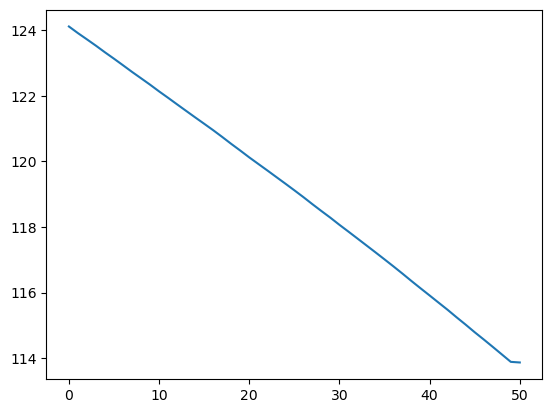

In [9]:
plt.plot(RMSE_list)